In [ ]:
%pip install jovian --upgrade

In [2]:
import jovian
jovian.commit(environment=None)

[jovian] Detected Colab notebook...
[jovian] jovian.commit() is no longer required on Google Colab. If you ran this notebook from Jovian, 
then just save this file in Colab using Ctrl+S/Cmd+S and it will be updated on Jovian. 
Also, you can also delete this cell, it's no longer necessary.


In [ ]:
# clone darknet repo
%git clone https://github.com/AlexeyAB/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 15903, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 15903 (delta 0), reused 1 (delta 0), pack-reused 15900 (from 1)
Receiving objects: 100% (15903/15903), 14.46 MiB | 11.21 MiB/s, done.
Resolving deltas: 100% (10703/10703), done.


In [ ]:
# change makefile to have GPU and OPENCV enabled
%cd darknet
%sed -i 's/OPENCV=0/OPENCV=1/' Makefile
%sed -i 's/GPU=0/GPU=1/' Makefile
%sed -i 's/CUDNN=0/CUDNN=1/' Makefile

/content/darknet


In [5]:
# verify CUDA
!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0


In [6]:
# make darknet (build)
!make

mkdir -p ./obj/
mkdir -p backup
mkdir -p results
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -rdynamic -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:945:23: warning: variable ‘rgb’ set but not used []8;;https://gcc.gnu.org/onlinedocs/gcc/Warning-Options.html#index-Wunused-but-set-variable-Wunused-but-set-variable]8;;]
  945 |                 float rgb[3];
      |                       ^~~
./src/image_opencv.cpp: In function ‘void cv_draw_object(image, float*, int, int, int*, float*, int*, int, char**)’:
./src/image_opencv.cpp:1443:14: warning: unused variable ‘bu

In [7]:
# get yolov3 pretrained coco dataset weights
!wget https://pjreddie.com/media/files/yolov3.weights

--2025-08-19 09:17:40--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 172.67.185.199, 104.21.88.156, 2606:4700:3037::6815:589c, ...
Connecting to pjreddie.com (pjreddie.com)|172.67.185.199|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘yolov3.weights’

yolov3.weights          [ <=>                ]   8.88K  --.-KB/s    in 0s      

2025-08-19 09:17:41 (70.2 MB/s) - ‘yolov3.weights’ saved [9093]



In [8]:
# Download YOLOv3 weights from a valid mirror
!wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov3.weights -O yolov3.weights


# Verify the file size
!ls -lh yolov3.weights


--2025-08-19 09:17:44--  https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov3.weights
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/75388965/e42c2500-9016-11ea-92ba-11df9f79f31b?sp=r&sv=2018-11-09&sr=b&spr=https&se=2025-08-19T10%3A00%3A47Z&rscd=attachment%3B+filename%3Dyolov3.weights&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4de&skt=2025-08-19T09%3A00%3A16Z&ske=2025-08-19T10%3A00%3A47Z&sks=b&skv=2018-11-09&sig=RQ4vVdCqliDueg%2Bxbo1bE3NEC0HJgbD5kC96e8dfMYM%3D&jwt=eyJ0eXAiOiJKV1QiLCJhbGciOiJIUzI1NiJ9.eyJpc3MiOiJnaXRodWIuY29tIiwiYXVkIjoicmVsZWFzZS1hc3NldHMuZ2l0aHVidXNlcmNvbnRlbnQuY29tIiwia2V5Ijoia2V5MSIsImV4cCI6MTc1NTU5NTM2NCwibmJmIjoxNzU1NTk1MDY0LCJwYXRoIjoicmVsZWFzZWFzc2V0cHJvZ

In [9]:
# define helper functions
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()

# use this to upload files
def upload():
  from google.colab import files
  uploaded = files.upload()
  for name, data in uploaded.items():
    with open(name, 'wb') as f:
      f.write(data)
      print ('saved file', name)

# use this to download a file
def download(path):
  from google.colab import files
  files.download(path)

In [11]:
from google.colab import files

# Upload your test image (e.g. mypic.jpg)
uploaded = files.upload()

# Move it into darknet's data folder
for filename in uploaded.keys():
    !mv "{filename}" /content/darknet/data/
    print(f"Image moved to /content/darknet/data/{filename}")

Saving hooma.jpg to hooma.jpg
Image moved to /content/darknet/data/hooma.jpg


In [17]:
%cd /content/darknet

!./darknet detect cfg/yolov3_V1_config.cfg /content/darknet/yolov3.weights data/hooma.jpg -dont_show

/content/darknet
 GPU isn't used 
 OpenCV version: 4.5.4
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
Unused field: 'Downsample = (null)'
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
Unused field: 'Downsample = (null)'
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5,  wt = 0, wn = 0, outputs: 104 x 104 x 128 0.001 BF
   9 conv     64       1 x 1/ 1    104

In [15]:
%cd /content/darknet
!make clean

# Recompile with CPU only (disable GPU, CUDNN, OPENCV)
!sed -i 's/GPU=1/GPU=0/' Makefile
!sed -i 's/CUDNN=1/CUDNN=0/' Makefile
!sed -i 's/CUDNN_HALF=1/CUDNN_HALF=0/' Makefile

!make

!./darknet detect cfg/yolov3_V1_config.cfg /content/darknet/yolov3.weights data/hooma.jpg -dont_show


/content/darknet
rm -rf ./obj/image_opencv.o ./obj/http_stream.o ./obj/gemm.o ./obj/utils.o ./obj/dark_cuda.o ./obj/convolutional_layer.o ./obj/list.o ./obj/image.o ./obj/activations.o ./obj/im2col.o ./obj/col2im.o ./obj/blas.o ./obj/crop_layer.o ./obj/dropout_layer.o ./obj/maxpool_layer.o ./obj/softmax_layer.o ./obj/data.o ./obj/matrix.o ./obj/network.o ./obj/connected_layer.o ./obj/cost_layer.o ./obj/parser.o ./obj/option_list.o ./obj/darknet.o ./obj/detection_layer.o ./obj/captcha.o ./obj/route_layer.o ./obj/writing.o ./obj/box.o ./obj/nightmare.o ./obj/normalization_layer.o ./obj/avgpool_layer.o ./obj/coco.o ./obj/dice.o ./obj/yolo.o ./obj/detector.o ./obj/layer.o ./obj/compare.o ./obj/classifier.o ./obj/local_layer.o ./obj/swag.o ./obj/shortcut_layer.o ./obj/representation_layer.o ./obj/activation_layer.o ./obj/rnn_layer.o ./obj/gru_layer.o ./obj/rnn.o ./obj/rnn_vid.o ./obj/crnn_layer.o ./obj/demo.o ./obj/tag.o ./obj/cifar.o ./obj/go.o ./obj/batchnorm_layer.o ./obj/art.o ./obj/reg

/content/darknet
 GPU isn't used 
 OpenCV version: 4.5.4
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5,  wt = 0, wn = 0, outputs: 104 x 104 x 128 0.001 BF
   9 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
  10 conv    128       3 x 3/ 1

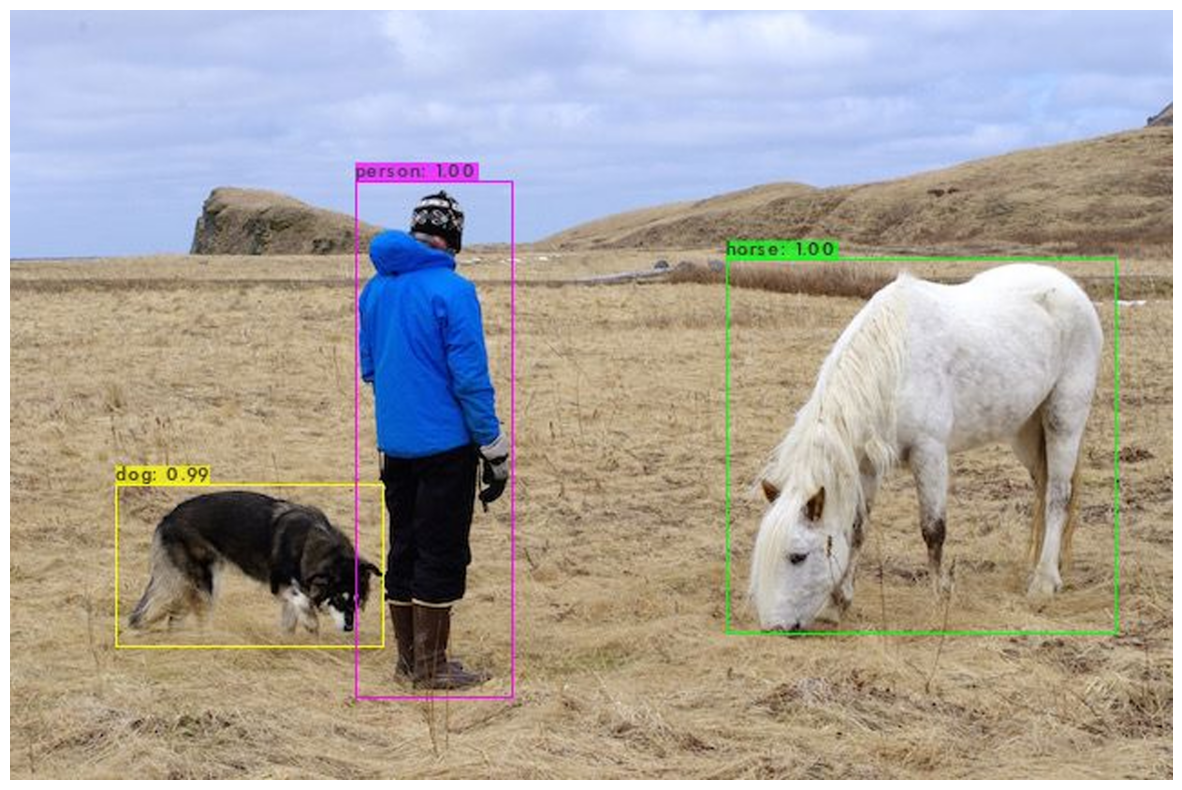

In [16]:
# run darknet detection
%cd /content/darknet

!./darknet detect cfg/yolov3.cfg yolov3.weights data/person.jpg
imShow('/content/darknet/predictions.jpg')

 GPU isn't used 
 OpenCV version: 4.5.4
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5,  wt = 0, wn = 0, outputs: 104 x 104 x 128 0.001 BF
   9 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
  10 conv    128       3 x 3/ 1    104 x 104 x  

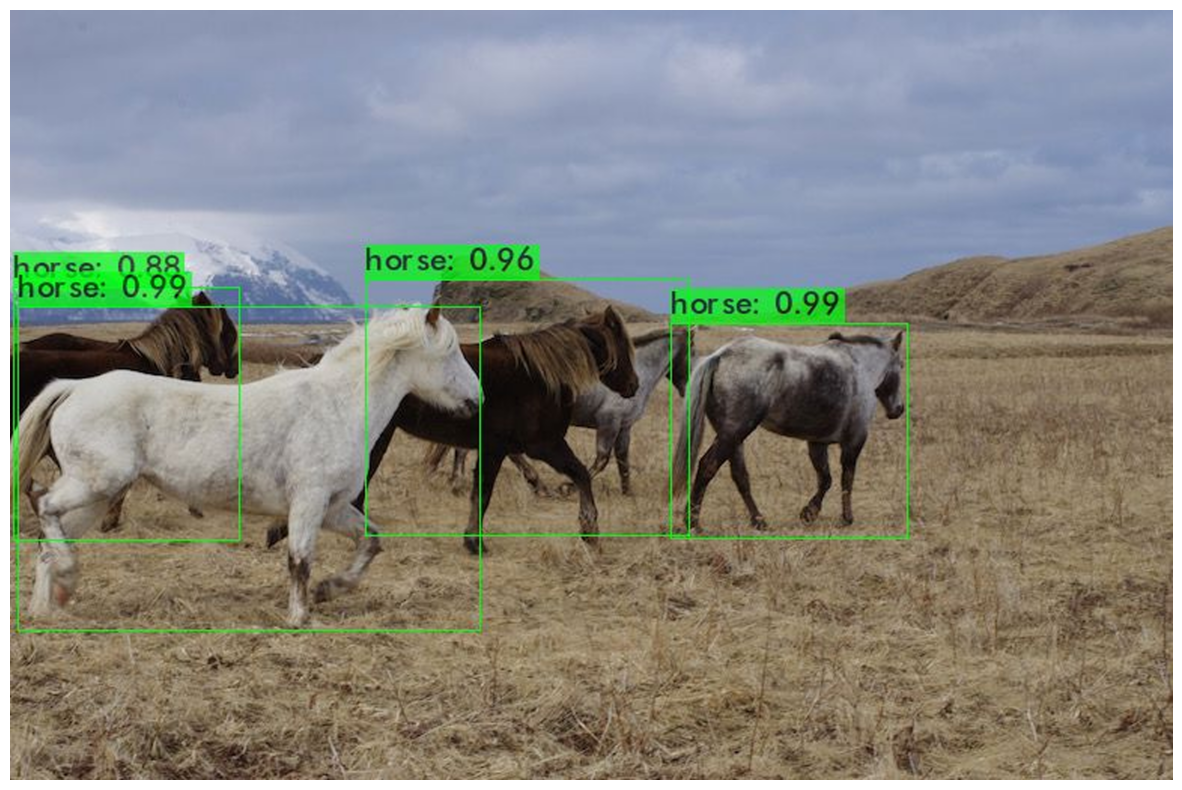

In [18]:
# look we can run another detection!
!./darknet detect cfg/yolov3.cfg yolov3.weights data/horses.jpg
imShow('predictions.jpg')

In [19]:
# this creates a symbolic link so that now the path /content/gdrive/My\ Drive/ is equal to /mydrive
!ln -s /content/gdrive/My\ Drive/ /Mydrive

In [20]:
!ls /Mydrive

/Mydrive


[Errno 20] Not a directory: 'darknet'
/content/darknet
 GPU isn't used 
 OpenCV version: 4.5.4
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5,  wt = 0, wn = 0, outputs: 104 x 104 x 128 0.001 BF
   9 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.

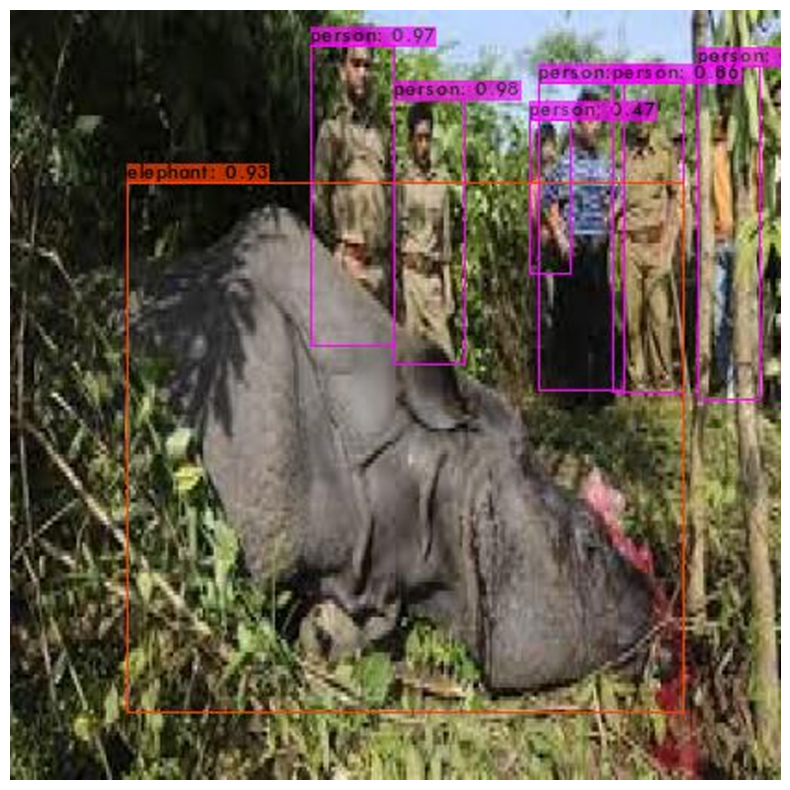

In [21]:
# run darknet command with google drive image (my image path is /images/plane.jpg)
%cd darknet
!./darknet detect cfg/yolov3.cfg yolov3.weights /content/5.jpg
imShow('predictions.jpg')

In [22]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [23]:
!ls /content/drive/MyDrive/wildlife/


backup		   obj.data   obj.zip	   train.txt
generate_train.py  obj.names  test_images  yolov3_V1_config.cfg


In [24]:
!cp /content/drive/MyDrive/wildlife/obj.zip ../

In [25]:
!zip -r /content/obj.zip /content/drive/MyDrive/wildlife/obj.zip


  adding: content/drive/MyDrive/wildlife/obj.zip (stored 0%)


In [26]:
!pwd

/content/darknet


In [27]:
# unzip the zip file and its contents should now be in /darknet/data/obj
!unzip ../obj.zip -d data/

Archive:  ../obj.zip
   creating: data/test/
  inflating: data/test/0212-banteng-hunter-Picture5_jpg.rf.7c638f678ed1ecf7f6f76a3810329b4c.jpg  
  inflating: data/test/0212-banteng-hunter-Picture5_jpg.rf.7c638f678ed1ecf7f6f76a3810329b4c.txt  
  inflating: data/test/0212-banteng-hunter-Picture5_jpg.rf.b28992cdc688e5a18fbf407b036d7066.jpg  
  inflating: data/test/0212-banteng-hunter-Picture5_jpg.rf.b28992cdc688e5a18fbf407b036d7066.txt  
  inflating: data/test/0212-banteng-hunter-Picture5_jpg.rf.f6c14b05d918cdc780bb8c4db4b19878.jpg  
  inflating: data/test/0212-banteng-hunter-Picture5_jpg.rf.f6c14b05d918cdc780bb8c4db4b19878.txt  
  inflating: data/test/0212-banteng-poacher-semiautomatic-Picture3_jpg.rf.96f4fe3a6d99febcb724e6d4a5fcb699.jpg  
  inflating: data/test/0212-banteng-poacher-semiautomatic-Picture3_jpg.rf.96f4fe3a6d99febcb724e6d4a5fcb699.txt  
  inflating: data/test/185890-sambalpur-web_jpg.rf.3197cc256d2753787a91377d2d7b7939.jpg  
  inflating: data/test/185890-sambalpur-web_jpg.rf.

In [28]:
!ls data/

9k.tree     dog.jpg	 hooma.jpg		   labels	     test
coco9k.map  eagle.jpg	 horses.jpg		   openimages.names  voc.names
coco.names  giraffe.jpg  imagenet.labels.list	   person.jpg
content     goal.txt	 imagenet.shortnames.list  scream.jpg


In [29]:
from pathlib import Path

obj_folder = Path("data/obj")
train_file = Path("data/train.txt")

with train_file.open("w") as f:
    for img_path in obj_folder.glob("*.jpg"):
        f.write(str(img_path).replace("\\","/") + "\n")  # replace backslashes for Windows


In [30]:
!ls data/

9k.tree     dog.jpg	 hooma.jpg		   labels	     test
coco9k.map  eagle.jpg	 horses.jpg		   openimages.names  train.txt
coco.names  giraffe.jpg  imagenet.labels.list	   person.jpg	     voc.names
content     goal.txt	 imagenet.shortnames.list  scream.jpg


In [31]:
import os

# Path where your images actually are
obj_path = "/content/darknet/data/test"

image_files = []
for filename in os.listdir(obj_path):
    if filename.endswith(".jpg"):
        image_files.append(os.path.join(obj_path, filename))

# Save train.txt in the same folder as Darknet expects
train_txt_path = "/content/darknet/data/train.txt"
with open(train_txt_path, "w") as outfile:
    for image in image_files:
        outfile.write(image.replace("\\","/") + "\n")  # safe for Darknet

print(f"train.txt created with {len(image_files)} images!")


train.txt created with 129 images!


In [32]:
# Step 1: Create a folder to store weights
!mkdir -p /content/wildlife_weights

# Step 2: Download YOLOv3 full pre-trained weights (optional, for detection)
!wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov3.weights \
      -O /content/wildlife_weights/yolov3.weights

# Step 3: Download pre-trained convolutional weights for training custom dataset
!wget https://data.pjreddie.com/files/darknet53.conv.74 \
      -O /content/wildlife_weights/darknet53.conv.74

# Step 4: Verify downloaded files
!ls -lh /content/wildlife_weights


--2025-08-19 09:28:45--  https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov3.weights
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/75388965/e42c2500-9016-11ea-92ba-11df9f79f31b?sp=r&sv=2018-11-09&sr=b&spr=https&se=2025-08-19T10%3A04%3A17Z&rscd=attachment%3B+filename%3Dyolov3.weights&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4de&skt=2025-08-19T09%3A03%3A46Z&ske=2025-08-19T10%3A04%3A17Z&sks=b&skv=2018-11-09&sig=Wao606%2Ff3DMSqNE%2Faztdb1Mjz%2Fcta7L394fjujsrX%2FY%3D&jwt=eyJ0eXAiOiJKV1QiLCJhbGciOiJIUzI1NiJ9.eyJpc3MiOiJnaXRodWIuY29tIiwiYXVkIjoicmVsZWFzZS1hc3NldHMuZ2l0aHVidXNlcmNvbnRlbnQuY29tIiwia2V5Ijoia2V5MSIsImV4cCI6MTc1NTU5NjAyNSwibmJmIjoxNzU1NTk1NzI1LCJwYXRoIjoicmVsZWFzZWFzc2V

In [33]:
!ls -lh /content/wildlife_weights


total 237M
-rw-r--r-- 1 root root    0 Aug 19 09:28 darknet53.conv.74
-rw-r--r-- 1 root root 237M Dec  8  2021 yolov3.weights


In [34]:
!wget https://sourceforge.net/projects/yolov3.mirror/files/v8/darknet53.conv.74/download -O /content/wildlife_weights/darknet53.conv.74

--2025-08-19 09:30:28--  https://sourceforge.net/projects/yolov3.mirror/files/v8/darknet53.conv.74/download
Resolving sourceforge.net (sourceforge.net)... 104.18.12.149, 104.18.13.149, 2606:4700::6812:d95, ...
Connecting to sourceforge.net (sourceforge.net)|104.18.12.149|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://downloads.sourceforge.net/project/yolov3.mirror/v8/darknet53.conv.74?ts=gAAAAABopEQ0OXTDfmctFjoqipdOGK2g-xqKBRzSW6vvk3JTcmo_LuSCBq9J4kYgzvICn73vKQ9LutAGr0VEBl0kbFEdg5gETQ%3D%3D&use_mirror=altushost-swe&r= [following]
--2025-08-19 09:30:28--  https://downloads.sourceforge.net/project/yolov3.mirror/v8/darknet53.conv.74?ts=gAAAAABopEQ0OXTDfmctFjoqipdOGK2g-xqKBRzSW6vvk3JTcmo_LuSCBq9J4kYgzvICn73vKQ9LutAGr0VEBl0kbFEdg5gETQ%3D%3D&use_mirror=altushost-swe&r=
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 104.18.13.149, 104.18.12.149, 2606:4700::6812:d95, ...
Connecting to downloads.sourceforge.net (downloads.sourceforge.n

In [35]:
!ls -lh /content/wildlife_weights/darknet53.conv.74

-rw-r--r-- 1 root root 155M Nov 18  2020 /content/wildlife_weights/darknet53.conv.74


In [38]:
# train your custom detector
!./darknet detector train data/obj.data cfg/yolov3_V1_config.cfg /content/wildlife_weights/darknet53.conv.74 -dont_show

 GPU isn't used 
 OpenCV version: 4.5.4
yolov3_V1_config
mini_batch = 4, batch = 64, time_steps = 1, train = 1 
   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
Unused field: 'Downsample = (null)'
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
Unused field: 'Downsample = (null)'
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5,  wt = 0, wn = 0, outputs: 104 x 104 x 128 0.001 BF
   9 conv     64       1 x 1/ 1    104

In [40]:
import os
print(os.listdir())   # shows files in current folder


['DarknetConfig.cmake.in', 'darknet_video.py', 'image_yolov3.sh', 'obj', 'include', '.gitignore', 'vcpkg.json', 'Makefile', 'build.ps1', 'build', 'darknet', 'backup', 'video_yolov3.sh', '.circleci', 'scripts', 'darknet.py', 'image_yolov4.sh', '.github', '3rdparty', 'src', 'video_yolov4.sh', 'data', 'docker-compose.yml', 'json_mjpeg_streams.sh', 'darknet_images.py', 'yolov3.weights', 'Dockerfile.gpu', 'cfg', '.git', 'CMakeLists.txt', 'cmake', 'Dockerfile.cpu', 'README.md', 'results', 'predictions.jpg', 'net_cam_v3.sh', 'package.xml', 'LICENSE', 'net_cam_v4.sh']


In [41]:
!./darknet detector train data/obj.data cfg/yolov3_V1_config.cfg /content/drive/MyDrive/wildlife/backup/yolov3_V1_config_last.weights -dont_show

 GPU isn't used 
 OpenCV version: 4.5.4
yolov3_V1_config
mini_batch = 4, batch = 64, time_steps = 1, train = 1 
   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
Unused field: 'Downsample = (null)'
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
Unused field: 'Downsample = (null)'
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5,  wt = 0, wn = 0, outputs: 104 x 104 x 128 0.001 BF
   9 conv     64       1 x 1/ 1    104

In [43]:
!cp cfg/yolov3.cfg cfg/yolov3_custom.cfg


In [44]:
# need to set our custom cfg to test mode
%cd cfg
!sed -i 's/batch=64/batch=1/' yolov3_custom.cfg
!sed -i 's/subdivisions=16/subdivisions=1/' yolov3_V1_config.cfg
%cd ..


/content/darknet/cfg
/content/darknet


 GPU isn't used 
 OpenCV version: 4.5.4
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
Unused field: 'Downsample = (null)'
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
Unused field: 'Downsample = (null)'
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5,  wt = 0, wn = 0, outputs: 104 x 104 x 128 0.001 BF
   9 conv     64       1 x 1/ 1    104 x 104 x 128 ->  1

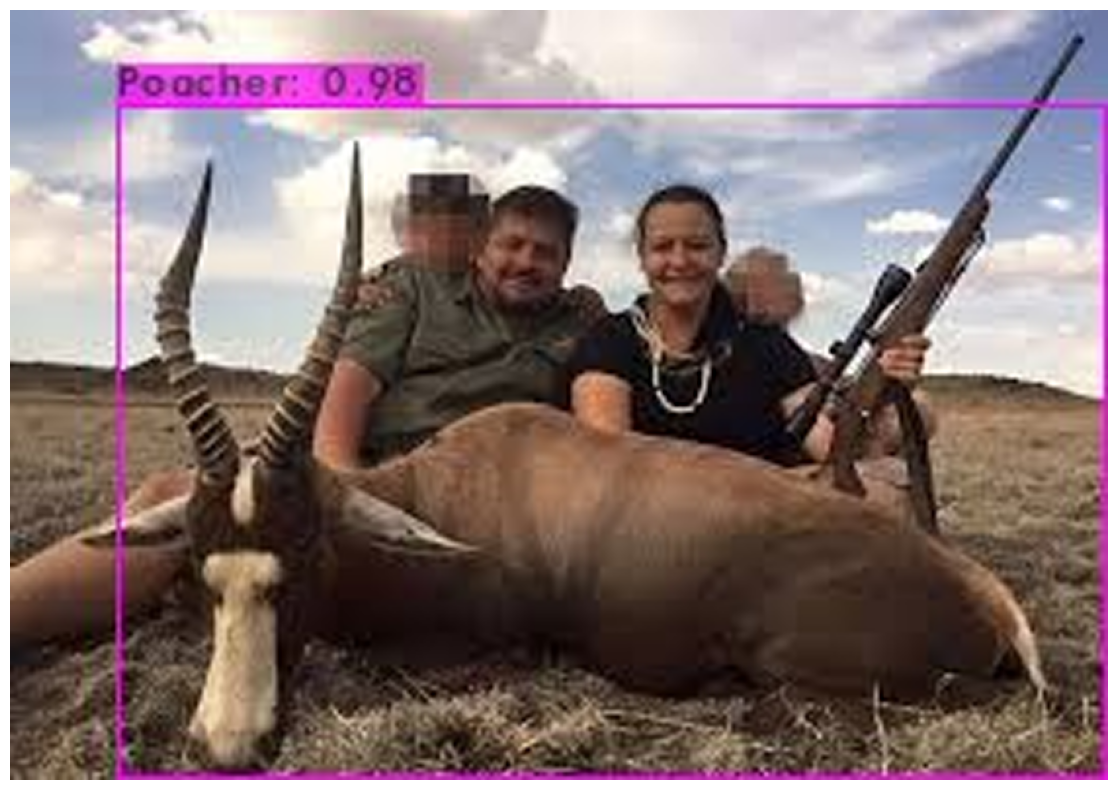

In [45]:
# run your custom detector with this command (upload an image to your google drive to test, thresh flag sets accuracy that detection must be in order to show it)
!./darknet detector test data/obj.data cfg/yolov3_V1_config.cfg /content/drive/MyDrive/wildlife/backup/yolov3_V1_config_last.weights /content/drive/MyDrive/wildlife/pic2.jpg -thresh 0.3 -dont_show
imShow('predictions.jpg')